<a href="https://colab.research.google.com/github/hoanganh1105/scann-approximate-nearest-neighbor/blob/main/ScaNN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scann==1.4.0 matplotlib pandas scikit-learn


Tạo tập dữ liệu N=200000, D=128...
Bắt đầu đánh giá (Q=50, N=200000)...

--- Xây dựng Ground Truth (Brute Force - CPU) ---
BruteForce (CPU): 97.66 MB
BruteForce (CPU): Đã fit NearestNeighbors trong 12.38 ms

--- Xây dựng Indexes ScaNN (CPU) ---
Đang build ScaNN (Nén 4x) trên CPU với params: {'leaves': 512, 'n_search': 100, 'dims_block': 1, 'reorder': 1000}
  Bắt đầu build ScaNN (CPU)...
  ScaNN (Nén 4x): 21417.55 ms build, 24.66 MB (CPU)

--- Đang tính Ground Truth (Cho K=200, 50 queries)... ---
Đã tính GT cho 10/50 queries (T_avg: 130.84 ms)
Đã tính GT cho 20/50 queries (T_avg: 131.49 ms)
Đã tính GT cho 30/50 queries (T_avg: 130.83 ms)
Đã tính GT cho 40/50 queries (T_avg: 130.61 ms)
Đã tính GT cho 50/50 queries (T_avg: 131.31 ms)
--- Đang đánh giá ScaNN... ---
Hoàn thành K=1
Hoàn thành K=10
Hoàn thành K=50
Hoàn thành K=100
Hoàn thành K=200

📈 KẾT QUẢ SO SÁNH (N=200000, CPU, ScaNN-4x vs BruteForce)
Chi tiết thời gian xây dựng (ms) và bộ nhớ (Ước tính):
| Method             |   Build Ti

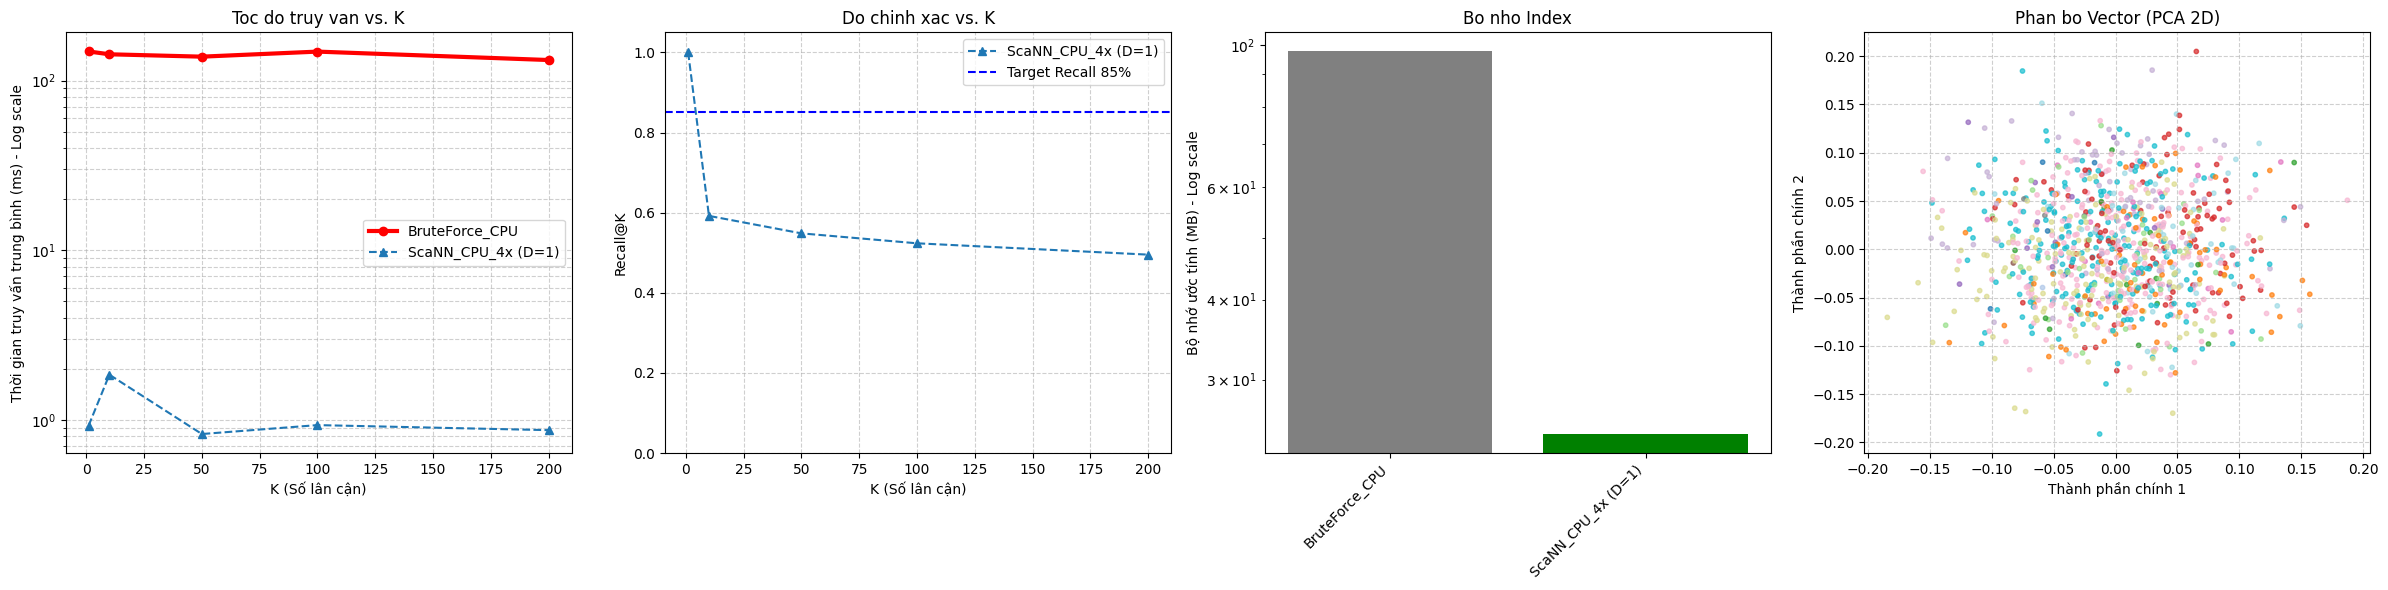

In [ ]:
# Cell 2: Import và Chạy (Chỉ chạy sau khi đã Restart Session)

import time, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.neighbors import NearestNeighbors
import scann
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import os

# --- TẮT CẢNH BÁO ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.cluster import MiniBatchKMeans
# --- KẾT THÚC TẮT CẢNH BÁO ---

# ================================================================
# ⚙️ TIỆN ÍCH CHUNG
# ================================================================
def now_ms(): return time.perf_counter() * 1000

def create_dataset(n=200000, d=128): # THAY ĐỔI: N=200K (approx 100MB)
    print(f"Tạo tập dữ liệu N={n}, D={d}...")
    rng = np.random.RandomState(42)
    x = rng.rand(n, d).astype(np.float32)
    # Chuẩn hóa L2 cho các metric cosine/dot_product
    normalize(x, norm='l2', axis=1, copy=False)
    return x

def get_memory_usage_mb(arr): return arr.nbytes / (1.0 * 1024 * 1024)

# Danh sách K_VALUES toàn cục (theo yêu cầu)
K_VALUES = [1, 10, 50, 100, 200]

# ================================================================
# 📘 ĐỊNH NGHĨA CÁC THUẬT TOÁN
# ================================================================

# --- 1. Brute Force (Baseline - CPU) ---
class BruteForce:
    def __init__(self, data, metric='cosine'):
        self.data = data
        self.metric = metric
        self.d = data.shape[1]
        self.memory_mb = get_memory_usage_mb(data)
        self.build_time = 0
        print(f"BruteForce (CPU): {self.memory_mb:.2f} MB")

        t0 = now_ms()
        self.nn = NearestNeighbors(n_neighbors=max(K_VALUES), algorithm="brute", metric="cosine").fit(data)
        self.build_time = now_ms() - t0
        print(f"BruteForce (CPU): Đã fit NearestNeighbors trong {self.build_time:.2f} ms")


    def search(self, q, k):
        t0 = now_ms()
        if self.metric == 'cosine':
            _, idx = self.nn.kneighbors(q.reshape(1, -1), n_neighbors=k)
            idx = idx[0]
        else:
            dists = np.linalg.norm(self.data - q.reshape(1, -1), axis=1)
            idx = np.argsort(dists)[:k]
        return idx, now_ms() - t0

# --- 2. ScaNN (Chỉ Nén 4x - CPU) ---
class ScaNNIndex:
    # THAY ĐỔI: Tinh chỉnh tham số cho N=200k
    def __init__(self, data, max_k=200, dims_per_block=1, num_leaves=512, n_search=100, reorder_k=1000):
        self.d = data.shape[1]
        self.dims_per_block = dims_per_block

        # Tính toán nén
        self.num_subquantizers = self.d // self.dims_per_block
        self.compressed_size_bytes = self.num_subquantizers
        self.original_size_bytes = self.d * 4
        self.compression_ratio = self.original_size_bytes / self.compressed_size_bytes

        self.params = {
            "leaves": num_leaves,
            "n_search": n_search,
            "dims_block": dims_per_block,
            "reorder": reorder_k
        }
        print(f"Đang build ScaNN (Nén {self.compression_ratio:.0f}x) trên CPU với params: {self.params}")

        total_t0 = now_ms()
        print("  Bắt đầu build ScaNN (CPU)...")

        builder = scann.scann_ops_pybind.builder(data, max_k, "dot_product") \
            .tree(num_leaves=num_leaves, num_leaves_to_search=n_search, training_sample_size=min(50000, len(data))) \
            .score_ah(dims_per_block, anisotropic_quantization_threshold=0.2)
            # <-- SỬA LỖI LOGIC
        self.searcher = builder.build()
        self.build_time = now_ms() - total_t0

        # Ước tính bộ nhớ
        overhead_mb = (num_leaves * self.d * 4) / (1024*1024)
        data_mem_mb = (data.shape[0] * self.compressed_size_bytes) / (1024*1024)
        self.memory_mb = data_mem_mb + overhead_mb

        print(f"  ScaNN (Nén {self.compression_ratio:.0f}x): {self.build_time:.2f} ms build, {self.memory_mb:.2f} MB (CPU)")

    def search(self, q, k):
        t0 = now_ms()
        idx, _ = self.searcher.search_batched(q.reshape(1, -1), final_num_neighbors=k)
        return idx[0], now_ms() - t0

# ================================================================
# 📊 HÀM ĐÁNH GIÁ (Đã rút gọn)
# ================================================================
def recall(gt, pred):
    return len(set(gt) & set(pred)) / len(gt)

def evaluate_all(data, d=128, nq=50, ks=[1, 10, 50, 100, 200]):
    print(f"Bắt đầu đánh giá (Q={nq}, N={len(data)})...")

    max_k_eval = max(ks)

    print("\n--- Xây dựng Ground Truth (Brute Force - CPU) ---")
    bf = BruteForce(data, metric='cosine')

    print("\n--- Xây dựng Indexes ScaNN (CPU) ---")

    # THAY ĐỔI: Cấu hình cho N=200k
    N_LEAVES = 512
    N_SEARCH = 100
    REORDER_K = 1000

    indexes = {
        # CHỈ SO SÁNH NÉN 4x
        "ScaNN_CPU_4x (D=1)": ScaNNIndex(data, max_k=max_k_eval, dims_per_block=1, num_leaves=N_LEAVES, n_search=N_SEARCH, reorder_k=REORDER_K),
    }

    query_indices = np.random.choice(len(data), nq, replace=False)
    queries = data[query_indices]

    results = []

    # 1. Lấy Ground Truth
    print(f"\n--- Đang tính Ground Truth (Cho K={max_k_eval}, {nq} queries)... ---")
    gt_map = {}
    bf_k_max_time = 0.0
    for i in range(nq):
        q = queries[i]
        gt_idx, t_ = bf.search(q, max_k_eval)
        gt_map[i] = gt_idx
        bf_k_max_time += t_
        if (i+1)%10 == 0:
            print(f"Đã tính GT cho {i+1}/{nq} queries (T_avg: {bf_k_max_time/(i+1):.2f} ms)")

    # 2. Đánh giá từng K
    print("--- Đang đánh giá ScaNN... ---")
    for k in ks:
        if k > max_k_eval: continue

        k_gts = {i: set(gt_map[i][:k]) for i in range(nq)}

        res_k = {"K": k}

        # Đánh giá Brute Force (chỉ thời gian)
        bf_time = 0.0
        for i, q in enumerate(queries):
            _, t_ = bf.search(q, k)
            bf_time += t_
        res_k["BruteForce_Time(ms)"] = bf_time / nq
        res_k["BruteForce_Recall@K"] = 1.0

        # Đánh giá các index ScaNN
        for name, index in indexes.items():
            ann_time = 0.0
            ann_recall = 0.0
            for i, q in enumerate(queries):
                pred_idx, t_ = index.search(q, k)
                ann_time += t_
                ann_recall += recall(k_gts[i], pred_idx)

            res_k[f"{name}_Time(ms)"] = ann_time / nq
            res_k[f"{name}_Recall@K"] = ann_recall / nq

        print(f"Hoàn thành K={k}")
        results.append(res_k)

    # 3. Thu thập thông tin Build
    build_stats = {"Method": ["BruteForce_CPU"] + list(indexes.keys())}
    build_stats["Build Time (ms)"] = [bf.build_time] + [idx.build_time for idx in indexes.values()]
    build_stats["Memory (MB)"] = [bf.memory_mb] + [idx.memory_mb for idx in indexes.values()]

    build_df = pd.DataFrame(build_stats)
    results_df = pd.DataFrame(results)

    print("\n" + "="*80)
    print(f"📈 KẾT QUẢ SO SÁNH (N={len(data)}, CPU, ScaNN-4x vs BruteForce)")
    print("="*80)
    print("Chi tiết thời gian xây dựng (ms) và bộ nhớ (Ước tính):")
    print(build_df.to_markdown(index=False))
    print("\nChi tiết hiệu năng truy vấn (ms) và độ chính xác (Recall@K):")
    print(results_df.to_markdown(index=False))

    # Lưu lại index và data để Cell 3 có thể sử dụng
    if "ScaNN_CPU_4x (D=1)" in indexes:
        evaluate_all.scann_index = indexes["ScaNN_CPU_4x (D=1)"]
    evaluate_all.data_cache = data

    return results_df, build_df, data

# ================================================================
# 🎨 TRỰC QUAN HÓA (Đã cập nhật)
# ================================================================
def plot_all(results_df, build_df, data_plot):
    plt.figure(figsize=(24, 6)) # Thu hẹp lại còn 1 hàng

    methods = build_df["Method"][1:] # Chỉ lấy ScaNN

    # 1. Biểu đồ Thời gian truy vấn (log scale)
    plt.subplot(1, 4, 1)
    plt.plot(results_df["K"], results_df["BruteForce_Time(ms)"], 'r-o', label='BruteForce_CPU', lw=3)
    for name in methods:
        plt.plot(results_df["K"], results_df[f"{name}_Time(ms)"], marker='^', linestyle='--', label=name)
    plt.yscale('log')
    plt.xlabel("K (Số lân cận)")
    plt.ylabel("Thời gian truy vấn trung bình (ms) - Log scale")
    plt.title("Toc do truy van vs. K")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.6)

    # 2. Biểu đồ Recall@K
    plt.subplot(1, 4, 2)
    for name in methods:
        plt.plot(results_df["K"], results_df[f"{name}_Recall@K"], marker='^', linestyle='--', label=name)
    plt.xlabel("K (Số lân cận)")
    plt.ylabel("Recall@K")
    plt.title("Do chinh xac vs. K")
    plt.ylim(0, 1.05)
    plt.axhline(y=0.85, color='b', linestyle='--', label='Target Recall 85%')
    plt.legend()
    plt.grid(True, ls="--", alpha=0.6)

    # 3. Biểu đồ Bộ nhớ
    plt.subplot(1, 4, 3)
    bars = plt.bar(build_df["Method"], build_df["Memory (MB)"], color=['gray', 'green'])
    plt.ylabel("Bộ nhớ ước tính (MB) - Log scale")
    plt.yscale('log')
    plt.title("Bo nho Index")
    plt.xticks(rotation=45, ha='right')

    # 4. Biểu đồ Phân bố Vector (PCA)
    plt.subplot(1, 4, 4)
    print("\nĐang chạy PCA (1000 điểm) và K-Means (16 cụm) để tô màu...")

    sample_indices = np.random.choice(data_plot.shape[0], 1000, replace=False)
    data_sample = data_plot[sample_indices]

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_sample)

    kmeans = MiniBatchKMeans(n_clusters=16, random_state=42, n_init=3, batch_size=256)
    labels = kmeans.fit_predict(data_sample)

    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab20', alpha=0.7, s=10)
    plt.title("Phan bo Vector (PCA 2D)")
    plt.xlabel("Thành phần chính 1")
    plt.ylabel("Thành phần chính 2")
    plt.grid(True, ls="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig("scann_compression_benchmark_cpu_4x_100MB.png")
    print("Đã lưu biểu đồ tổng thể vào 'scann_compression_benchmark_cpu_4x_100MB.png'")

# ================================================================
# 🚀 MAIN (MỚI)
# ================================================================
if __name__ == "__main__":
    N_SAMPLES = 200000 # 200K vector (approx 100MB)
    DIM = 128
    K_VALUES = [1, 10, 50, 100, 200] # K hợp lý

    DATA = create_dataset(N_SAMPLES, DIM)
    results_df, build_df, data_plot = evaluate_all(DATA, d=DIM, nq=50, ks=K_VALUES)
    plot_all(results_df, build_df, DATA)

Đã tải ScaNN Index và DATA từ Cell 2.
Đang chạy PCA (10000 mẫu) để chuẩn bị biểu đồ...
Đang chạy truy vấn và vẽ biểu đồ...

Đã lưu biểu đồ trực quan hóa vào 'scann_query_visualization_100MB.png'


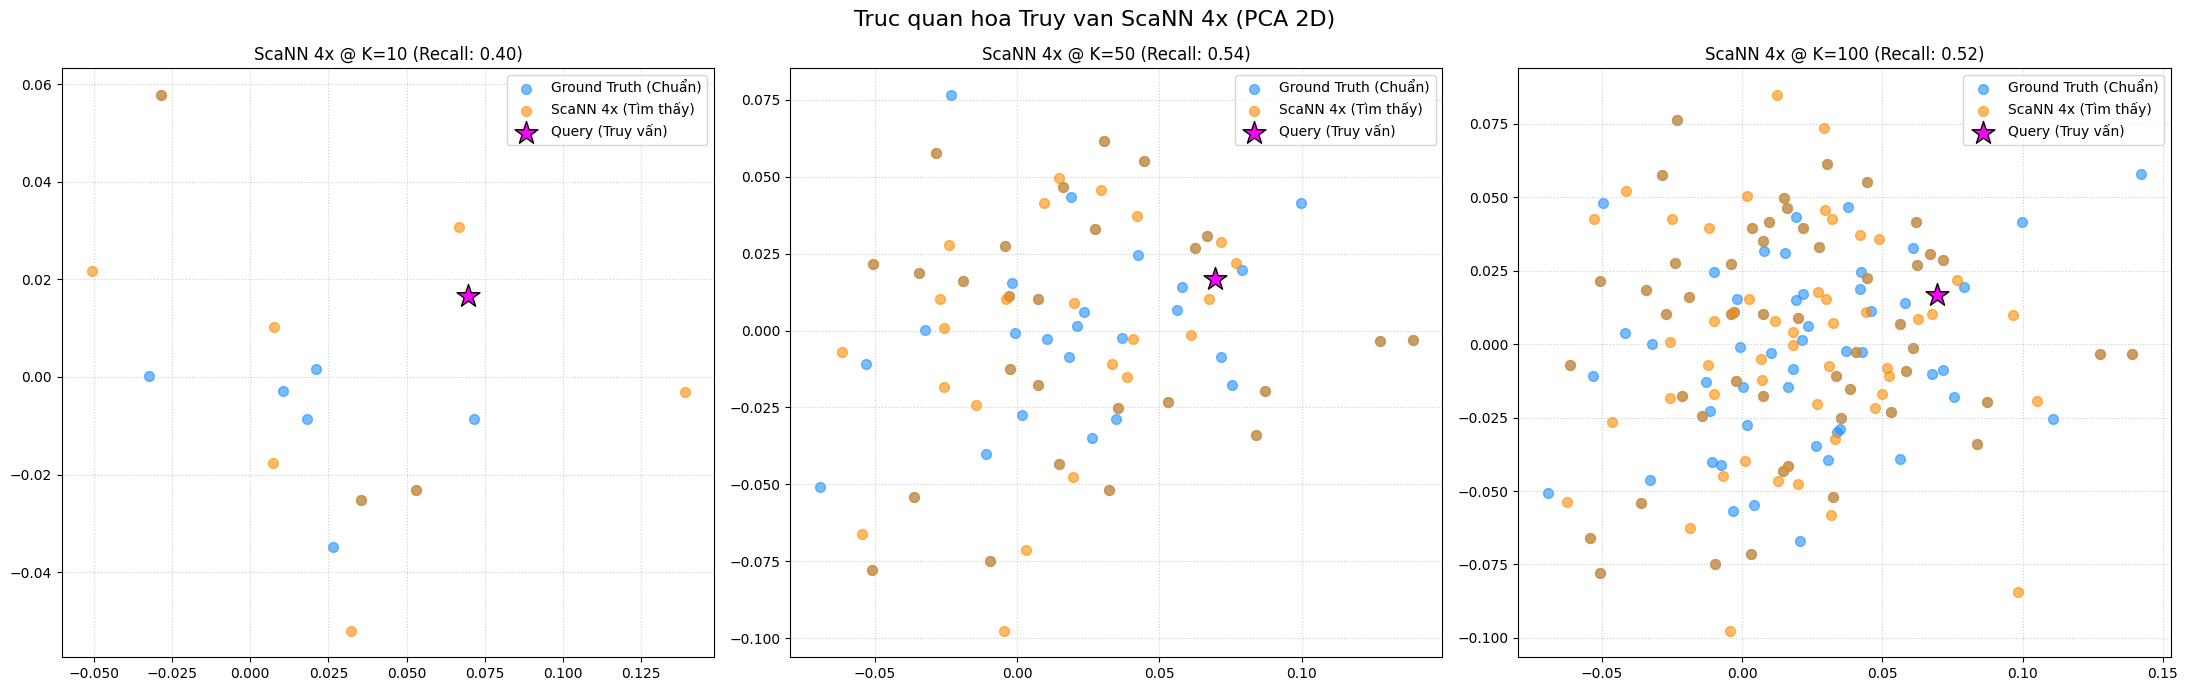

In [ ]:
# Cell 3: Trực quan hóa một Truy vấn Đơn lẻ

# (Phải chạy sau Cell 1 và Cell 2)

try:
    # Lấy index ScaNN (bản 4x) và DATA từ kết quả của Cell 2
    scann_index_4x = evaluate_all.scann_index
    DATA = evaluate_all.data_cache
    print("Đã tải ScaNN Index và DATA từ Cell 2.")

    # Chọn 1 query ngẫu nhiên
    q_idx = np.random.choice(DATA.shape[0])
    q_vec = DATA[q_idx]

    # Các mức K bạn muốn xem
    Ks = [10, 50, 100]

    # Giảm chiều dữ liệu xuống 2D để vẽ
    print("Đang chạy PCA (10000 mẫu) để chuẩn bị biểu đồ...")
    sample_indices = np.random.choice(DATA.shape[0], 10000, replace=False)
    data_sample = DATA[sample_indices]

    pca = PCA(n_components=2)
    pca.fit(data_sample) # Fit PCA

    # Chuyển đổi điểm truy vấn sang 2D
    q_vec_2d = pca.transform(q_vec.reshape(1, -1))

    # Tạo biểu đồ
    fig, axes = plt.subplots(1, len(Ks), figsize=(22, 7))
    if len(Ks) == 1:
        axes = [axes] # Đảm bảo axes luôn là một danh sách

    print("Đang chạy truy vấn và vẽ biểu đồ...")
    for i, K in enumerate(Ks):
        ax = axes[i]

        # SỬA LỖI (TypeError): Đổi 'final_num_neighbors=K' thành 'k=K'
        neighbors_idx, _ = scann_index_4x.search(q_vec, k=K)

        # Lấy Ground Truth (chạy Brute Force cho K này)
        # Chúng ta dùng DATA (toàn bộ 200k điểm) để tìm ground truth
        bf_searcher_viz = NearestNeighbors(n_neighbors=K, algorithm="brute", metric="cosine").fit(DATA)
        _, gt_idx = bf_searcher_viz.kneighbors(q_vec.reshape(1, -1))
        gt_idx = gt_idx[0]

        # Tính toán Recall cho truy vấn này
        recall = len(set(gt_idx) & set(neighbors_idx)) / K

        # Chuyển đổi các điểm lân cận sang 2D
        neighbors_vecs_2d = pca.transform(DATA[neighbors_idx])
        gt_vecs_2d = pca.transform(DATA[gt_idx])

        # Vẽ các điểm Ground Truth (Màu xanh)
        ax.scatter(gt_vecs_2d[:, 0], gt_vecs_2d[:, 1],
                   c='dodgerblue', alpha=0.6, s=50, label=f'Ground Truth (Chuẩn)')

        # Vẽ các điểm ScaNN tìm được (Màu cam)
        ax.scatter(neighbors_vecs_2d[:, 0], neighbors_vecs_2d[:, 1],
                   c='darkorange', alpha=0.6, s=50, label=f'ScaNN 4x (Tìm thấy)')

        # Vẽ điểm truy vấn (Ngôi sao)
        ax.scatter(q_vec_2d[:, 0], q_vec_2d[:, 1],
                   c='magenta', marker='*', s=300, edgecolor='black', label='Query (Truy vấn)')

        ax.set_title(f"ScaNN 4x @ K={K} (Recall: {recall:.2f})")
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.suptitle("Truc quan hoa Truy van ScaNN 4x (PCA 2D)", fontsize=16)
    plt.tight_layout()
    plt.savefig("scann_query_visualization_100MB.png")
    print("\nĐã lưu biểu đồ trực quan hóa vào 'scann_query_visualization_100MB.png'")
    plt.show()

except AttributeError:
    print("⚠️ LỖI: Không tìm thấy 'evaluate_all.scann_index' hoặc 'evaluate_all.data_cache'.")
    print("Vui lòng đảm bảo bạn đã chạy Cell 2 (code benchmark chính) thành công trước khi chạy cell này.")
except NameError:
    print("⚠️ LỖI: Hàm 'evaluate_all' chưa được định nghĩa.")
    print("Vui lòng đảm bảo bạn đã chạy Cell 2 (code benchmark chính) thành công trước khi chạy cell này.")